**Tests on GPU usage locally**

In [75]:
# !pip install pycuda
import torch
import pycuda.driver as cuda
cuda.init()
# Get Id of default device
torch.cuda.current_device()
# 0
cuda.Device(0).name() # '0' is the id of your GPU)

'NVIDIA GeForce RTX 2070 with Max-Q Design'

In [13]:
# !nvcc --version


nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Jun__8_16:59:34_Pacific_Daylight_Time_2022
Cuda compilation tools, release 11.7, V11.7.99
Build cuda_11.7.r11.7/compiler.31442593_0


In [1]:
import torch
torch.cuda.is_available()

True

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


**Start of the project**

Import modules

In [11]:
import torch
from torchvision import datasets, transforms
import numpy as np
import timeit
from collections import OrderedDict
from pprint import pformat
import matplotlib.pyplot as plt

**Start of examples tests**

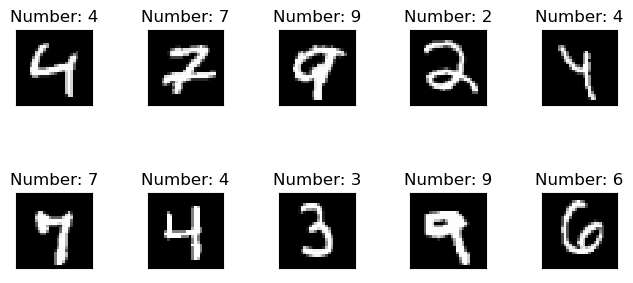

In [74]:
mnist_example = datasets.MNIST('data', train=False, download=True,
                                transform=transforms.Compose([
                                  torchvision.transforms.ToTensor(),
                                    transforms.Normalize((0.1307,), (0.3081,)),
                                ])
                                )
# train_loader = torch.utils.data.DataLoader(MNIST_training_set,batch_size=batch_size_train, shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_example,batch_size=50, shuffle=True)
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
import matplotlib.pyplot as plt
fig = plt.figure()
for i in range(10):
  plt.subplot(3,5,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Number: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

**end of examples tests**

Function to compute your base score 

In [15]:
def compute_base_score(acc, min_thres, max_thres):
    if acc <= min_thres:
        base_score = 0.0
    elif acc >= max_thres:
        base_score = 100.0
    else:
        base_score = float(acc - min_thres) / (max_thres - min_thres) \
                     * 100
    return base_score

In [16]:
def compute_runtime_factor(runtime, min_thres, max_thres):
    if runtime <= min_thres:
        score_factor = 1
    elif runtime >= max_thres:
        score_factor = 0
    else:
        score_factor = 0.5

    return score_factor

Function to run your k-NN algorithm and compute its accuracy and runtime

In [17]:
def run(x_train, y_train, x_test, y_test, n_classes, device, n_runs):
    if device != 'cpu' and torch.cuda.is_available():
        device = torch.device("cuda")
        print('Running on GPU: {}'.format(torch.cuda.get_device_name(0)))
    else:
        device = torch.device("cpu")
        print('Running on CPU')

    run_times = []

    for i in range(n_runs):
        start = timeit.default_timer()
        # np.random.seed(0)
        predicted_y_test = knn(x_train, y_train, x_test, n_classes, device)
        # np.random.seed()
        stop = timeit.default_timer()
        run_time = stop - start
        run_times.append(run_time)

        print(f'run {i + 1} : run_time: {run_time}')

    assert isinstance(predicted_y_test, np.ndarray), "predicted test labels must be returned as a numpy array"

    correct_predict = (y_test
                       == predicted_y_test).astype(np.int32).sum()
    accuracy = float(correct_predict) / len(y_test)

    run_time = min(run_times)

    print('Correct Predictions: {}/{} total \tAccuracy: {:5f} \tTime: {:2f}'.format(correct_predict,
                                                                                    len(y_test), accuracy, run_time))
    return correct_predict, accuracy, run_time

**Implementation of knn here**

In [82]:
def knn(x_train, y_train, x_test, n_classes, device):
    """
    x_train: 60000 x 784 matrix: each row is a flattened image of an MNIST digit
    y_train: 60000 vector: label for x_train
    x_test: 1000 x 784 testing images
    n_classes: no. of classes in the classification task
    device: pytorch device on which to run the code
    return: predicted y_test which is a 1000-sized vector
    """
    """
    x_train: 60000 x 784 matrix: each row is a flattened image of an MNIST digit
    y_train: 60000 vector: label for x_train
    x_test: 5000 x 784 testing images
    return: predicted y_test which is a 5000 vector
    """
    # Convert data from numpy arrays to pytorch tensors
    x_train_tensor = torch.tensor(x_train,dtype=torch.float, device= device)
    y_train_tensor = torch.tensor(y_train,dtype=torch.float, device= device)
    x_test_tensor = torch.tensor(x_test,dtype=torch.float, device= device)
    predicted_y_test_tensor = torch.zeros((x_test.shape[0]),dtype=torch.float,device= device)
    # Choose value for k
    k = 4
    # initize one hot vector
    
    
    # print(y_train)
    for i in range(x_test_tensor.shape[0]):
    # for i, x_tset_img in enumerate(x_test_tensor):
        # Choose a distance function and 
        #distances = x_train_tensor.norm(x_tset_img,dim =1, dtype= torch.float)
        
        x_tset_img = x_test_tensor[i]
        # Manhattan
        # distances = torch.nn.L1Loss(x_train_tensor, x_tset_img)

        # Cosine
        # distances = torch.nn.functional.cosine_similarity(x_train_tensor, x_tset_img,dim=1)

        # L_p
        # distances = torch.nn.PairwiseDistance(x_train_tensor, x_tset_img)

        # Euclidean
        distances= torch.norm(x_train_tensor - x_tset_img,dim=1)

        # Find indices of k training images with the smallest distances
        topk = torch.topk(distances,k,largest= False)[1]
        # Get classes of the corresponding training images
        corresponding_classes = torch.gather(y_train_tensor.type(torch.int64),0,topk)

        #option 1: Accuracy: 0.962000 	Time: 2.576361 | better time with less accuracy
        # #####
        # argmax = torch.argmax(torch.nn.functional.one_hot(corresponding_classes, num_classes=n_classes))
        # predicted_y_test_tensor[i]= argmax
        ####
        #option 2: Accuracy: 0.964000 	Time: 2.631409 | better accuracy with more time
        #####
        mode = int(torch.mode(corresponding_classes)[0])
        predicted_y_test_tensor[i]= mode
    

    return predicted_y_test_tensor.cpu().numpy()

    # raise NotImplementedError


Main function

In [23]:
def main():
    min_acc_thres = 0.84
    max_acc_thres = 0.94

    min_runtime_thres = 12
    max_runtime_thres = 24

    n_runs = 5

    n_classes = 10
    # change to cpu to run on CPU
    device = 'gpu'

    mnist_train = datasets.MNIST('data', train=True, download=True,
                                 transform=transforms.Compose([
                                     transforms.Normalize((0.1307,), (0.3081,)),
                                 ])
                                 )
    mnist_test = datasets.MNIST('data', train=False, download=True,
                                transform=transforms.Compose([
                                    transforms.Normalize((0.1307,), (0.3081,)),
                                ])
                                )
    # convert pytorch tensors to numpy arrays
    (x_train, y_train) = (mnist_train.data.cpu().numpy(), mnist_train.targets.cpu().numpy())
    (x_valid, y_valid) = (mnist_test.data.cpu().numpy(), mnist_test.targets.cpu().numpy())

    # flatten 28x28 images into 784 sized vectors
    x_train = x_train.reshape(x_train.shape[0], -1)
    x_valid = x_valid.reshape(x_valid.shape[0], -1)

    # You may want to use a smaller training set to save time when debugging
    # i.e.: Put something like:
    # (x_train, y_train) = (x_train[:5000], y_train[:5000])

    # For this assignment, we only test on the first 1000 samples of the test set
    (x_valid, y_valid) = (x_valid[:1000], y_valid[:1000])

    print("Dimension of dataset: ")
    print("Train:", x_train.shape, y_train.shape, "\nTest:", x_valid.shape, y_valid.shape)

    (correct_predict, accuracy, run_time) = run(x_train, y_train, x_valid, y_valid, n_classes, device, n_runs)
    base_score = compute_base_score(accuracy, min_acc_thres, max_acc_thres)

    runtime_factor = compute_runtime_factor(run_time, min_runtime_thres, max_runtime_thres)

    overall_score = base_score * runtime_factor

    result = OrderedDict(correct_predict=correct_predict,
                         accuracy=accuracy,
                         run_time=run_time,
                         base_score=base_score,
                         overall_score=overall_score
                         )

    with open('result.txt', 'w') as f:
        f.writelines(pformat(result, indent=4))

    print(pformat(result, indent=4))

Call the main function. You can only run this after filling the _knn_ function above

In [83]:
main()

Dimension of dataset: 
Train: (60000, 784) (60000,) 
Test: (1000, 784) (1000,)
Running on GPU: NVIDIA GeForce RTX 2070 with Max-Q Design
run 1 : run_time: 3.1821975999998813
run 2 : run_time: 2.648881400000164
run 3 : run_time: 2.6614993000000595
run 4 : run_time: 2.6699005000000398
run 5 : run_time: 2.6638080000000173
Correct Predictions: 964/1000 total 	Accuracy: 0.964000 	Time: 2.648881
OrderedDict([   ('correct_predict', 964),
                ('accuracy', 0.964),
                ('run_time', 2.648881400000164),
                ('base_score', 100.0),
                ('overall_score', 100.0)])


In [79]:
main() #test after modifications using option 2

Dimension of dataset: 
Train: (60000, 784) (60000,) 
Test: (1000, 784) (1000,)
Running on GPU: NVIDIA GeForce RTX 2070 with Max-Q Design
run 1 : run_time: 3.075463500000069
run 2 : run_time: 2.6418014000000767
run 3 : run_time: 2.6436347999999725
run 4 : run_time: 2.6504655999999613
run 5 : run_time: 2.654219000000012
Correct Predictions: 964/1000 total 	Accuracy: 0.964000 	Time: 2.641801
OrderedDict([   ('correct_predict', 964),
                ('accuracy', 0.964),
                ('run_time', 2.6418014000000767),
                ('base_score', 100.0),
                ('overall_score', 100.0)])
